# Interpretované jazyky: lze v nich počítat efektivně?

### Aleš Křenek
### Sitsem, 9.9.2021, Telč


# Amdahl je kámoš

## Amdahlův zákon v praxi
- Řidič Pepa v 7:00 nastartuje dodávku s nářadím a jede na nejmenovanou brněnskou ulici. Cesta mu trvá 10 minut.
- Kopáč Fero nafasuje krumpáč a začne kopat. Ve 14:00 má hotovo a odchází na pivo.
- Kolikrát lze vykopání příkopu limitně zrychlit, dokážeme-li najmout potenciálně nekonečný počet kopáčů, pro všechny máme nářadí a vzájemně si nepřekáží?

### Negativní interpretace
- Žádný program nelze zrychlit přes jeho nejpomalejší (neparalelizovatelnou) část

### Pozitivní interpretace
- Nemá smysl snažit se urychlit části, které nejsou výkonově kritické
- Klidně mohou zůstat v pomalém interpretovaném jazyce (pohodlném na implementaci) a ničemu to nevadí

# Nenapíšeš cyklus!

## Násobení matic

In [56]:
loop_times = []
numpy_times = []

In [57]:
import random
from timeit import default_timer as timer

N = 300
A = [ [ random.random() for _ in range(N)] for _ in range(N)]
B = [ [ random.random() for _ in range(N)] for _ in range(N)]
C = [ [ 0. for _ in range(N)] for _ in range(N)]

In [58]:
start = timer()
for i in range(N):
    for j in range(N):
        for k in range(N):
            C[i][j] += A[i][k] * B[k][j]
            
end = timer()
loop_times.append(end-start)
sorted(loop_times)

[9.667369275121018]

### Pozorovaný výkon (GFLOPS)

In [59]:
mint = min(loop_times)
ops = 2 * N**3
ops / mint / 1e9

0.005585800900247913

### Očekávaný výkon


<table>
    <tr><th>Model</th><th>GHz</th><th>CPI</th><th>AVX</th><th>FMA</th><th>GFLOPS (float64)</th></tr>
    <tr><td>i7-4790K</td><td>4.00</td><td>0.5</td><td>256</td><td>ano</td><td>64</td></tr>
    <tr><td>i5-6600</td><td>3.3</td><td>0.5</td><td>256</td><td>ano</td><td>53</td></tr>
    <tr><td>Xeon Gold 6138</td><td>2.00</td><td>0.5</td><td>512</td><td>ano</td><td>64</td></tr>
    <tr><td>AMD Ryzen 3900X</td><td>3.80</td><td>0.5</td><td>256</td><td>ano</td><td>60</td></tr>
</table>

$$ \text{GFLOPS} = f / \text{CPI} * \text{AVX} / 64 * \text{FMA} $$


CPI viz http://uops.info/
    


In [60]:
N = 10000
import numpy as np
A = np.random.rand(N,N)
B = np.random.rand(N,N)

start = timer()
C = np.matmul(A,B)
end = timer()
numpy_times.append(end-start)
sorted(numpy_times)

[37.966913068899885]

In [61]:
# Pozorovaný výkon (GFLOPS)
mint = min(numpy_times)
ops = 2 * N**3
ops / mint / 1e9

52.677445658290154

In [62]:
# Není problém ve standardním pythonovém typu float?

N = 300
A = np.random.rand(N,N)
B = np.random.rand(N,N)
C = np.zeros((N,N))

start = timer()
for i in range(N):
    for j in range(N):
        for k in range(N):
            C[i][j] += A[i][k] * B[k][j]
            
end = timer()
end-start

28.4844352430664

## Stabilita trajektorie

- Vývoj nějakého procesu v čase -- posloupnost $m$ bodů $x_k\in R^n$
- Chceme zjistit, zda se děje ještě něco nového, nebo se vše podstatné už jen opakuje

- Korelace jednotlivých souřadnic
$$ c_{ij} = \sum_{k=1}^m (x_{ik} - \bar x_i) ( x_{jk} - \bar x_j) $$
kde $ \bar x_i = \sum_{k=1}^m x_{ki}/m$

- Největší vlastní hodnoty matice korelací (do součtu 90 % apod) postihují "to podstatné"
- Pokud se významně nezmění mezi např. 70 % a 100 % trajektorie, lze tvrdit, že už je stabilní
- Jako domácí cvičení z lineární algebry si rozmyslete, proč to funguje


In [63]:
import mdtraj as md

tr = md.load('pbc3.xtc',top='1L2Y.pdb')
idx=tr.top.select("protein and element != H")
# tr.atom_slice(idx,inplace=True)
tr

<mdtraj.Trajectory with 20001 frames, 304 atoms, 20 residues, and unitcells at 0x7fca05c0ef60>

In [64]:
tr.xyz.shape

(20001, 304, 3)

In [65]:
xyz = np.reshape(tr.xyz,(tr.xyz.shape[0],tr.xyz.shape[1]*3))

xyz_avg = np.average(xyz,axis=0)
xyz -= xyz_avg

cor = np.matmul(np.transpose(xyz),xyz)
cor /= xyz.shape[0]

eig = np.abs(np.sort(np.linalg.eigvalsh(cor)))

esum = np.sum(eig)
eig /= esum
eig = np.flip(eig)
eig[:10]

array([8.6611563e-01, 6.5118827e-02, 5.3016812e-02, 5.4081203e-03,
       3.6751181e-03, 1.5851937e-03, 6.8124972e-04, 6.0700055e-04,
       5.0445402e-04, 3.6924993e-04], dtype=float32)

In [66]:
tr2 = tr[:int(.8*tr.xyz.shape[0]):]
xyz2 = np.reshape(tr2.xyz,(tr2.xyz.shape[0],tr2.xyz.shape[1]*3))
xyz2_avg = np.average(xyz2,axis=0)
xyz2 -= xyz2_avg

cor2 = np.matmul(np.transpose(xyz2),xyz2)
cor2 /= xyz2.shape[0]

eig2 = np.abs(np.sort(np.linalg.eigvalsh(cor2)))

esum = np.sum(eig2)
eig2 /= esum
eig2 = np.flip(eig2)
eig2[:10]

array([8.22489083e-01, 1.00286655e-01, 5.54277375e-02, 7.26932101e-03,
       5.20591857e-03, 2.41178484e-03, 9.82072903e-04, 8.04731448e-04,
       7.52232329e-04, 5.42573223e-04], dtype=float32)

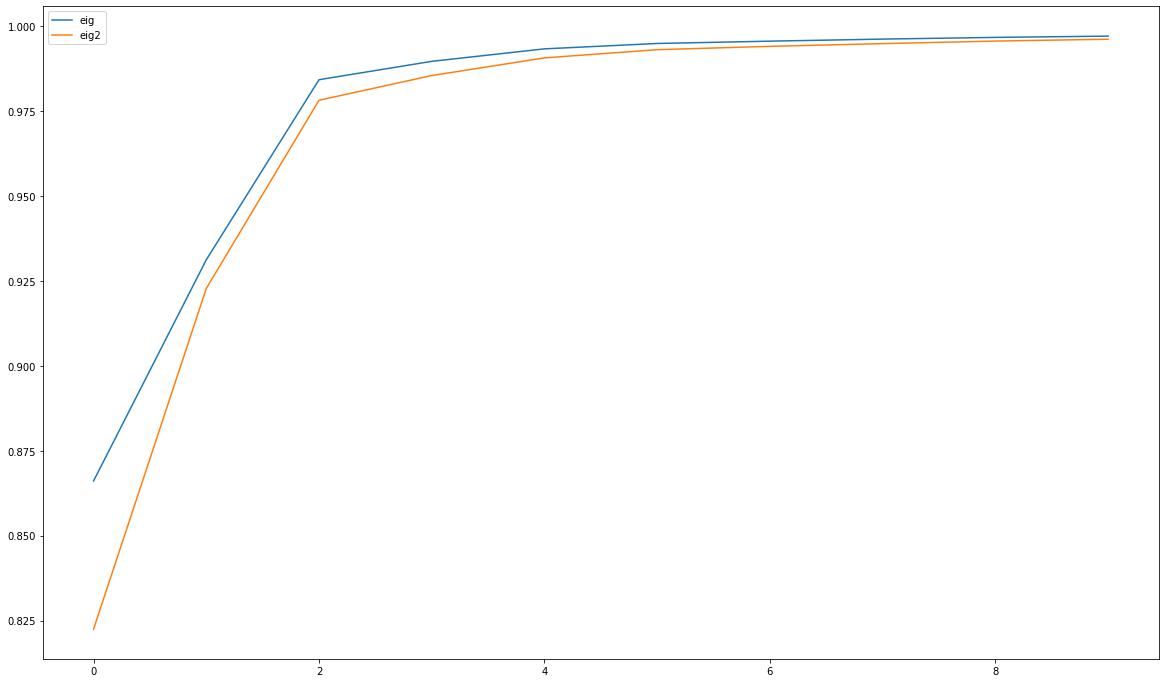

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,12))
plt.plot(np.cumsum(eig[:10]),label='eig')
plt.plot(np.cumsum(eig2[:10]),label='eig2')
plt.legend()
plt.show()

# Ať pracují jiní 


- triviální příklad -- hledání kořene funkce Newtonovou metodou
- máme vlastní funkci a umíme spočítat její derivaci

In [68]:
def myf(x,*freq):
    y = 0.
    for f in freq:
        y += np.sin(x*f)
    return y

def myfprime(x,*freq):
    yprime = 0.
    for f in freq:
        yprime = f*np.cos(x*f)
    return yprime

### Vlastní implementace

In [69]:
x = .5
freq = [1.2, 3.5, 4.2]
xs = []
for _ in range(15):
    xs.append(x)
    x -= myf(x,*freq) / myfprime(x, *freq)
print(xs)

[0.5, 1.6374695910121888, 1.36198464726053, 1.5123553118738675, 1.4639002494803997, 1.4802966644185476, 1.4753153175459273, 1.476873663976801, 1.4763908979638025, 1.4765409020058125, 1.4764943364156673, 1.476508795890053, 1.4765043063588927, 1.4765057003549766, 1.476505267523968]


### Použijeme knihovnu

In [70]:
from scipy.optimize import newton

x0 = .5
newton(myf,x0,args=freq,fprime=myfprime)

1.4765053731448787

## Knihovny vs. vlastní implementace
- Na FI jsem se naučil programovat, tak to chci dělat!
- Ale ... nemám-li vlastní původní algoritmus, pravděpodobně ho už naprogramoval někdo jiný
- Pro Python, R, ... existuje nepřeberné množství knihoven (různé kvality)
- Vemte na vědomí alespoň **numpy, scipy, pandas, sklearn, matplotlib**
  - Drtivá většina výpočetně náročných problémů se redukuje na metody v nich implementované
  - Jejich autoři věnovali vývoji více času než my a možná byli i chytřejší
  - V některých případech stojí za to implementace od Intelu (demo)
- Jinak napoví Google
  - Buďte ovšem připraveni na cokoli, zejména fenomén "vědeckého software"

# Náboženství GILu

## Jeden zámek vládne všem
- **Global Interpreter Lock** (GIL) je pragmatické řešení race-conditions při přístupu k paměťovým strukturám (tj. v podstatě cokoli v Pythonu)
- Ve srovnání se samostatnými zámky úspornější a rychlejší, nemůže dojít k deadlocku, šetrnější k rozšířením
- V tzv. "normálním" vícevláknovém kódu (čekání na I/O) ničemu nevadí
- Zabiják výpočetního kódu -- efektivně vše serializuje
- Zůstal v Pythonu3 ve většině mainstreamových implementací

## Co s tím?
1. Máte velké matice? Nechte to na numpy (demo).
  - implementace je "mimo Python", může si dělat, co chce
1. Balíky podporující "process pool" (multiprocessing, concurrent, ...)
  - různé konstrukce k pohodlnému použití více procesů (ne vláken)
  - vhodné k hrubozrnnému paralelismu (větší režie)
  - každý běží svoji instanci interpretu, tedy má i svůj GIL
1. Další knihovny (sklearn) mají paralelní implementace vyřešené
  - interně zpravidla process pool
1. Sáhněte k alternativní implementaci pythonu (pypy)

# A přece se kompiluje!

In [71]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [72]:
%%cython --annotate

import numpy as np
from timeit import default_timer as timer

cdef int N = 300
cdef int i,j,k
cdef double [:,:] A,B,C

A = np.random.rand(N,N)
B = np.random.rand(N,N)
C = np.zeros((N,N))
    
start = timer()
for i in range(N):
    for j in range(N):
        for k in range(N):
            C[i][j] += A[i][k] * B[k][j]
            
end = timer()

### Pozorovaný výkon

In [73]:
ops = 2 * N**3
print(end-start, ops / (end-start) / 1e9)

0.8227278410922736 0.06563531377315283


- řádový posun proti interpretovanému kódu
- srovnatelná naivní implementace v C 10-50x rychlejší